# **Measuring Bias in recommender systems**

This is an introduction to fairness in recommender systems. A recommender system aims to recommend the best item according to the user preference. In this tutorial, we will focus on the task of correctly predicting users' music preference.

A recommender system can be biased in multiple ways. For example, we may be concerned that the artists in our database will not get equal representation (item fairness). Alternative, our main concern may be that different groups of users (e.g. male/female users) will get different music recommendations (user fairness). In the following, we will show how to explore the data for fairness, and measure these various types of fairness using the holisticai library.

## Importing the data

First of all, we need to import the required packages to perform our bias analysis and mitigation. You will need to have the `holisticai` package installed on your system, remember that you can install it by running: 
```bash
!pip install holisticai[all]
```

We will start by importing the example dataset, which we host on our library. The [dataset](https://www.kaggle.com/datasets/ravichaubey1506/lastfm) contains a set of artists that were downloaded by users. It includes personal information about the user, specifically sex and country of origin. A user can download more than one artist. We will use the column "score", which contains only 1s for counting the interactions.

In [1]:
# Imports
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [2]:
from holisticai.datasets import load_dataset
dataset = load_dataset('lastfm')
df, p_attr = dataset['data_pivot'], dataset['p_attr']
df

,...and you will know us by the trail of dead,2pac,3 doors down,30 seconds to mars,311,36 crazyfists,44,50 cent,65daysofstatic,Edith piaf,...,weezer,wilco,within temptation,wolfgang amadeus mozart,wu-tang clan,yann tiersen,yeah yeah yeahs,yellowcard,yo la tengo,zero 7
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
14998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Plotting and Data Exploration

We will now move to data exploration, using some of the functions for plotting available in our library.

In [3]:
# import plotters
from holisticai.bias.plots import group_pie_plot
from holisticai.bias.plots import long_tail_plot
from holisticai.bias.plots import exposure_diff_plot
from holisticai.bias.plots import exposure_ratio_plot


In [4]:
print ('Number of Unique Users : ' + str(df.shape[0]))
print ('Number of Unique Artists : ' + str(df.shape[1]))

Number of Unique Users : 15000
Number of Unique Artists : 1004


<Axes: >

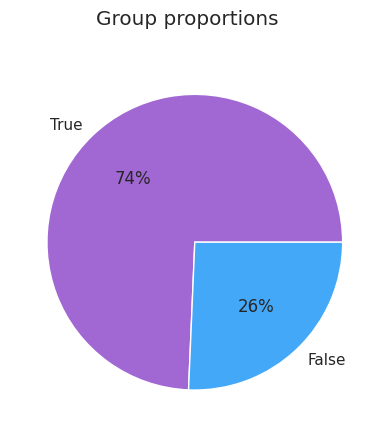

In [5]:
# male vs female representation in data
group_pie_plot(p_attr)

After an initial exploration of the users demographic, we can explore fairness-related plots. The `long_tail_plot` shows the descendent frequency of the items. In this example, the artists' popularity seems falls [exponentially](https://en.wikipedia.org/wiki/Zipf%27s_law) at a pretty fast rate. This can indicate an issue in terms of items fairness (i.e. if we want all artists to be recommended equally).

<Axes: title={'center': 'Long Tail Plot'}, xlabel='Items (sorted by popularity)', ylabel='Item Count'>

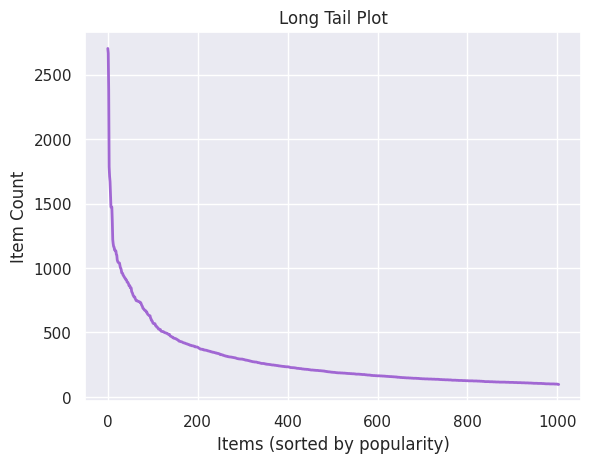

In [6]:
# the long tail plot shows the distribution of item counts
long_tail_plot(df.to_numpy())

If we are interested in users' fairness instead, we may want to compare how often the same artists are presented to different groups of users. Here, we will focus on the comparison between male and female users. Specifically, we calculate the proportion of male users (out of all male users) who have downloaded each artist. We then compare this value to the corresponding proportion of female users.

The holisticai function `exposure_diff_plot` displays the difference in exposure for each item, while `exposure_ratio_plot` measures the ratio in exposure.

<Axes: title={'center': 'Exposure Difference Plot'}, xlabel='Items (sorted by exposure difference)', ylabel='$Exposure_a - Exposure_b$'>

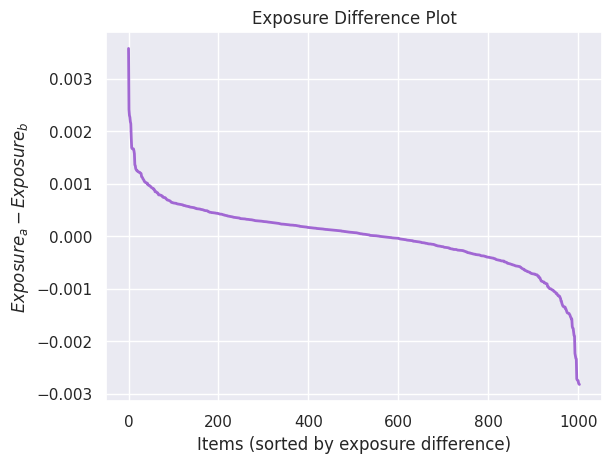

In [7]:
# sorted exposure differences
group_a = p_attr
group_b = ~p_attr
exposure_diff_plot(group_a, group_b, df.to_numpy())

The differences in exposures seem to be overall quite small. However, since the number of items is quite large, the exposures are small to start with. In these cases, the exposure ratio may be a more informative choice.

<Axes: title={'center': 'Exposure Ratio Plot'}, xlabel='Items (sorted by exposure ratio)', ylabel='$Exposure_a/Exposure_b$'>

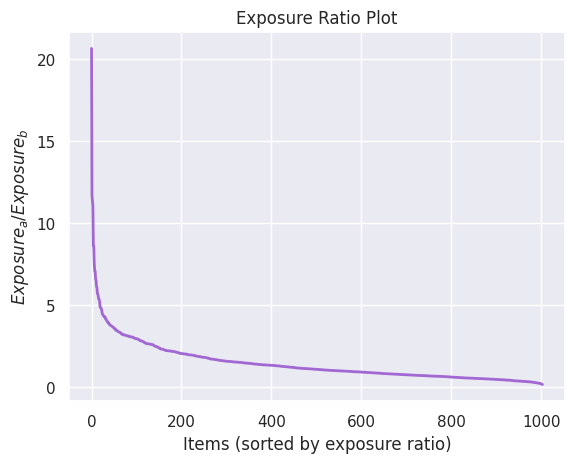

In [8]:
# sorted exposure ratios
exposure_ratio_plot(group_a, group_b, df.to_numpy())

<Axes: title={'center': 'Exposure Ratio Plot'}, xlabel='Items (sorted by exposure ratio)', ylabel='$Exposure_a/Exposure_b$'>

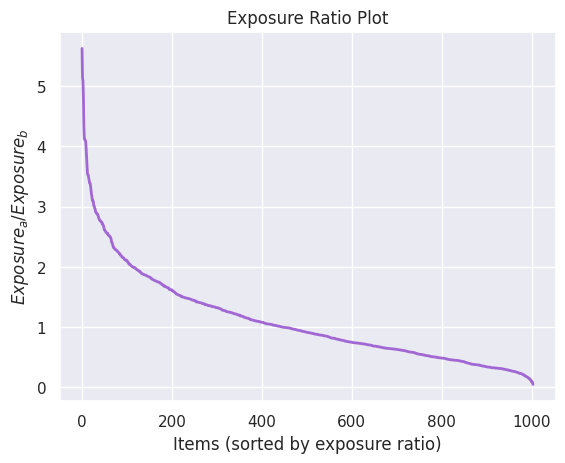

In [9]:
exposure_ratio_plot(group_b, group_a, df.to_numpy())

The above plots show that there are artists that are more than 5 times more popular amongst the female subgroup than male, and artists that are more than 20 times more popular amongst male rather than female users.

## Train a Model

There are many ways to recommend artists to users. We will use item based collaborative filtering since it is the simplest and most intuitive approach. For each artist, we work out a list of most similar artists. Then we recommend artists to users by looking at which artists they like, and choosing the most similar ones.

In [10]:
index_to_artist = dict(zip(range(len(df.columns)),df.columns))
artist_to_index = dict(zip(df.columns,range(len(df.columns))))
user_gender_dict = dict(zip(df.index, p_attr))

In [11]:
data_matrix = df.fillna(0).to_numpy()
data_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [12]:
# Import linear_kernel
from sklearn.metrics.pairwise import linear_kernel

# Compute the cosine similarity between items matrix
cosine_sim = linear_kernel(data_matrix.T, data_matrix.T)

cosine_sim.shape

(1004, 1004)

In [13]:
# Helper functions for display
def display_items(arr):
    return [index_to_artist[x] for x in arr]

# Items liked by a given user
def items_liked_by_user(data_matrix, u):
    return np.nonzero(data_matrix[u])[0]

display_items(items_liked_by_user(data_matrix, 9))

['mogwai',
 'my bloody valentine',
 'sonic youth',
 'stereolab',
 'the fall',
 'the kinks',
 'the radio dept.',
 'the velvet underground']

So user 9 happens to be a fan of Mogwai, nice.

In [14]:
def items_similar_to_item(similarity_matrix, i, k):
    arr = similarity_matrix[i]
    arr[i] = 0
    return np.argsort(arr)[-k:]

# Items similar to Mogwai
display_items(items_similar_to_item(cosine_sim, artist_to_index['mogwai'], 10))

['the beatles',
 'sonic youth',
 'muse',
 'portishead',
 'boards of canada',
 'coldplay',
 'death cab for cutie',
 'explosions in the sky',
 'sigur ros',
 'radiohead']

Ok so we want to train a model, we will take a simple approach. For each user we look at their liked items, then we create a list of similar items and choose the most frequent ones.

In [15]:
def recommended_items(data_matrix, similarity_matrix, u, k):
    liked = items_liked_by_user(data_matrix, u)
    arr = np.sum(similarity_matrix[liked,:], axis=0)
    arr[liked] = 0
    return np.argsort(arr)[-k:]
    

display_items(recommended_items(data_matrix, cosine_sim, 590, 10))

['the offspring',
 'green day',
 'rammstein',
 'foo fighters',
 'the killers',
 'led zeppelin',
 'muse',
 'radiohead',
 'coldplay',
 'red hot chili peppers']

Quantitative evaluation is possible, but we choose to evaluate our model qualitatively. Let's look at some examples to see if it makes sense.

In [16]:
# Items similar to 2 Pac
display_items(items_similar_to_item(cosine_sim, artist_to_index['2pac'], 10))

['t.i.',
 'the game',
 'dr. dre',
 '50 cent',
 'notorious b.i.g.',
 'snoop dogg',
 'jay-z',
 'nas',
 'eminem',
 'kanye west']

In [17]:
# Items similar to the beatles
display_items(items_similar_to_item(cosine_sim, artist_to_index['the beatles'], 10))

['nirvana',
 'the rolling stones',
 'queen',
 'david bowie',
 'led zeppelin',
 'red hot chili peppers',
 'bob dylan',
 'pink floyd',
 'coldplay',
 'radiohead']

In [18]:
# Items similar to madonna
display_items(items_similar_to_item(cosine_sim, artist_to_index['madonna'], 10))

['nelly furtado',
 'moby',
 'depeche mode',
 'michael jackson',
 'amy winehouse',
 'rihanna',
 'kylie minogue',
 'the beatles',
 'britney spears',
 'coldplay']

These all make sense to a human evaluator

In [19]:
recommendations = [display_items(recommended_items(data_matrix, cosine_sim, u, 10)) for u in range(df.shape[0])]

recomendation_df = pd.DataFrame(recommendations, columns = range(1,11))

recomendation_df

,1,2,3,4,5,6,7,8,9,10
0,system of a down,led zeppelin,foo fighters,pink floyd,nirvana,metallica,muse,radiohead,coldplay,the beatles
1,modest mouse,sufjan stevens,muse,pink floyd,death cab for cutie,beck,bjork,sigur ros,coldplay,the beatles
2,the white stripes,david bowie,daft punk,death cab for cutie,nirvana,the killers,red hot chili peppers,coldplay,the beatles,radiohead
3,queen,linkin park,nirvana,in flames,rammstein,led zeppelin,the beatles,pink floyd,red hot chili peppers,system of a down
4,linkin park,foo fighters,system of a down,led zeppelin,the killers,nirvana,red hot chili peppers,the beatles,coldplay,radiohead
...,...,...,...,...,...,...,...,...,...,...
14995,evanescence,daft punk,radiohead,metallica,system of a down,muse,moby,the killers,red hot chili peppers,coldplay
14996,rammstein,in flames,coldplay,pink floyd,muse,radiohead,nirvana,system of a down,the beatles,metallica
14997,the rolling stones,nirvana,depeche mode,muse,pink floyd,red hot chili peppers,the killers,radiohead,the beatles,coldplay
14998,the beatles,nelly furtado,muse,avril lavigne,lady gaga,the killers,linkin park,rihanna,britney spears,coldplay


In [20]:
def explode(arr, num_items):
    out = np.zeros(num_items)
    out[arr] = 1
    return out

new_recs = [explode(recommended_items(data_matrix, cosine_sim, u, 10), len(df.columns)) for u in range(df.shape[0])]

new_df_pivot = pd.DataFrame(new_recs, columns = df.columns)

new_df_pivot

,...and you will know us by the trail of dead,2pac,3 doors down,30 seconds to mars,311,36 crazyfists,44,50 cent,65daysofstatic,Edith piaf,...,weezer,wilco,within temptation,wolfgang amadeus mozart,wu-tang clan,yann tiersen,yeah yeah yeahs,yellowcard,yo la tengo,zero 7
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Evaluate Bias of Model

We will now show how we can calculate various metrics of fairness for recommender systems. In this example, we will cover both metrics for item fairness and for user fairness (equality of outcome).

### Item Fairness

In [21]:
mat = new_df_pivot.replace(0,np.nan).to_numpy()

<Axes: title={'center': 'Long Tail Plot'}, xlabel='Items (sorted by popularity)', ylabel='Item Count'>

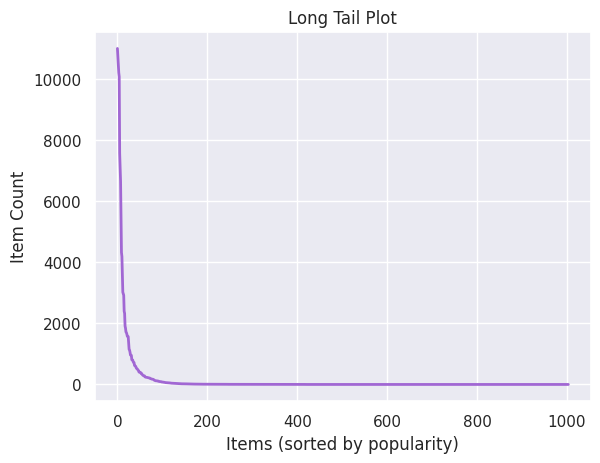

In [22]:
# the long tail plot shows the distribution of item counts
long_tail_plot(mat)

The item bias has been increased very considerably by using collaborative filtering. This is easily seen by the shape of the above distribution.

In [23]:
from holisticai.bias.metrics import aggregate_diversity
aggregate_diversity(mat)

np.float64(0.4163346613545817)

The above metric shows 40% of all artists are shown to at least one user.

In [24]:
from holisticai.bias.metrics import gini_index
gini_index(mat)

np.float64(0.9643764307078764)

The Gini Index is often used in the context of recommender systems as a measure of how unequal the distribution of exposure is over artists. A value of 0 would indicate perfect fairness, a flat distribution. A value of 1 would be maximally unequal. In this case the GINI Index is 0.96, indicating a VERY considerable amount of difference in exposures overall between different artists.

In [25]:
from holisticai.bias.metrics import recommender_bias_metrics
recommender_bias_metrics(mat_pred=mat, metric_type='item_based')

,Value,Reference
Metric,,
Aggregate Diversity,0.416335,1
GINI index,0.964376,0
Exposure Distribution Entropy,3.811466,-
Average Recommendation Popularity,5725.218920,-


Above we have batch plotted all item_based metrics for recommender bias task. For instance observe the Average Recommendation Popularity is 5716, meaning that on average a user will be recommended an artist that has 5716 total interactions.

## User fairness - Equality of Outcome

In [26]:
from holisticai.bias.metrics import exposure_l1
exposure_l1(group_a, group_b, mat)

np.float64(0.11132677015676723)

Above we compute the total variation distance between the exposure distribution of males and females. The minimum value for this metric is 0 indicating the two subgroups are exposed to the artists in exactly the same way, the maximum value is 1 indicating a maximal separation in exposures between the two groups. In this case the value of 0.11 shows there is a difference between the recommendations to males and females, but not a drastic one.